In [1]:
import numpy as np
import pandas as pd
import os
from librosa import feature
import librosa 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import IPython.display as ipd  # To play sound in the notebook
import librosa.display
import json
from matplotlib.pyplot import specgram
import seaborn as sns
import glob 
from tqdm import tqdm
import pickle
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
from torch.autograd import Variable
from torchvision import models
%matplotlib inline

In [2]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [3]:
from collections import defaultdict

In [4]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [5]:
genre_dict = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9,
    }

In [6]:
images = []
labels = []

In [7]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ]
)

In [10]:
%cd /content/drive/My Drive/Colab Notebooks/Music Informatics

/content/drive/My Drive/Colab Notebooks/Music Informatics


In [11]:
directory = './images/'

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        label = genre_dict[filename[:-9]]
        image = cv2.imread(os.path.join(directory, filename))
        image = transform2(image)
        images.append(image)
        labels.append(label)

In [12]:
print(len(images))

999


In [13]:
# check equal pixels
torch.sum(images[0] == images[100])

tensor(250753)

In [14]:
# check inequal pixels
torch.sum(images[0] != images[100])

tensor(122495)

In [15]:
#to_pil = transforms.ToPILImage()
#plt.imshow(to_pil(images[0]))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [17]:
X_train[0].size()

torch.Size([3, 288, 432])

In [18]:
torch_X_train = torch.stack(X_train).cuda()
torch_y_train = torch.cuda.LongTensor(y_train)

torch_X_test = torch.stack(X_test).cuda()
torch_y_test = torch.cuda.LongTensor(y_test)

In [19]:
print(torch_X_train.size())
print(torch_y_train.size())
print(torch_X_test.size())
print(torch_y_test.size())

torch.Size([799, 3, 288, 432])
torch.Size([799])
torch.Size([200, 3, 288, 432])
torch.Size([200])


In [20]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [21]:
BATCH_SIZE = 16

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [22]:
class MusicCNN(nn.Module):
    def __init__(self):
        super(MusicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.conv2 =nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.AvgPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.AvgPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=272384, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x=x.view(x.size(0), -1)

        #x = torch.transpose(x.view(x.size(0), x.size(1), -1), 1, 2)
        #x = F.dropout(F.relu(self.fc1(x)), 0.5)
        #x = F.dropout(F.relu(self.fc2(x)))
        #x = F.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = x.view(x.size(0), -1)
        return x

    def _init_weights(self, layer) -> None:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

In [23]:
model = MusicCNN()
model.cuda()
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
loss_plot = []
accuracy_plot = []
epoch_plot = []

In [25]:
EPOCHS = 50
model.train()
for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        # print(correct)
        if batch_idx % 399 == 0:
            print('Epoch : {}\t Loss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
            epoch_plot.append(epoch)
            accuracy_plot.append(float(correct*100) / float(BATCH_SIZE*(batch_idx+1)))
            loss_plot.append(loss.data)

Epoch : 0	 Loss: 2.300508	 Accuracy:12.500%
Epoch : 1	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 2	 Loss: 2.302585	 Accuracy:0.000%
Epoch : 3	 Loss: 2.302585	 Accuracy:12.500%
Epoch : 4	 Loss: 2.302585	 Accuracy:0.000%
Epoch : 5	 Loss: 2.302585	 Accuracy:25.000%
Epoch : 6	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 7	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 8	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 9	 Loss: 2.302585	 Accuracy:12.500%
Epoch : 10	 Loss: 2.302585	 Accuracy:18.750%
Epoch : 11	 Loss: 2.302585	 Accuracy:12.500%
Epoch : 12	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 13	 Loss: 2.302585	 Accuracy:0.000%
Epoch : 14	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 15	 Loss: 2.302585	 Accuracy:12.500%
Epoch : 16	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 17	 Loss: 2.302585	 Accuracy:18.750%
Epoch : 18	 Loss: 2.302585	 Accuracy:18.750%
Epoch : 19	 Loss: 2.302585	 Accuracy:0.000%
Epoch : 20	 Loss: 2.302585	 Accuracy:12.500%
Epoch : 21	 Loss: 2.302585	 Accuracy:6.250%
Epoch : 22	 Loss: 2.302585	 Accu

In [26]:
torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/Music Informatics/2D_CNN_melspec_images_all_samples.pth')

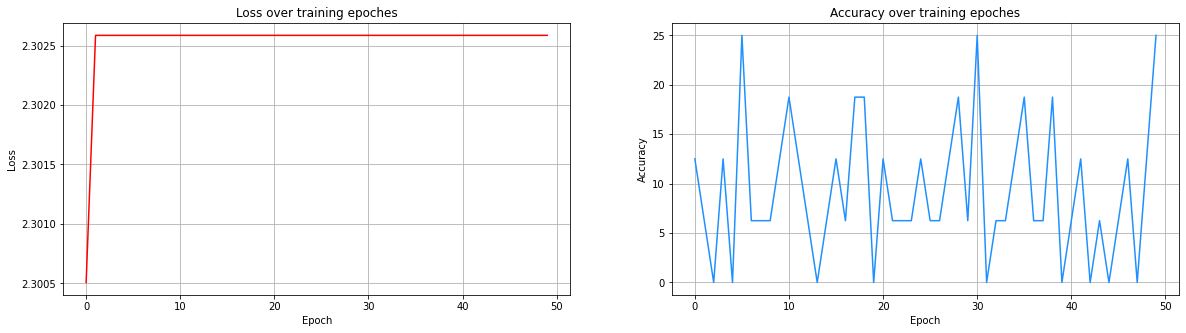

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].grid()
axs[0].plot(epoch_plot, loss_plot, color=colors['red'])
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[0].title.set_text('Loss over training epoches')

axs[1].grid()
axs[1].plot(epoch_plot, accuracy_plot, color=colors['dodgerblue'])
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1].title.set_text('Accuracy over training epoches')

In [28]:
model.eval()

MusicCNN(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=272384, out_features=1024, bias=True)
  (fc2): Linear(in_featur

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 13 %
